# Zebra page separation A/B Test Analysis Report 1: 
# Pageviews
__Jennifer Wang, Staff Data Scientist, Wikimedia Foundation__

July 2023

## TICKETS:
Instumentation planning : 
- Spec: [T333222](https://phabricator.wikimedia.org/T333222)

Instrumentation deployment :  
- Launch AB test: [T335972](https://phabricator.wikimedia.org/T335972)
- Fix bug: [T336969](https://phabricator.wikimedia.org/T336969) [T337955](https://phabricator.wikimedia.org/T337955)

Data tickets:
- Data QA: [T336299](https://phabricator.wikimedia.org/T336299)
- __Analysis: [T335379](https://phabricator.wikimedia.org/T335379)__

# Introduction

The Wikimedia Foundation's Web team is exploring a new page separation in vector-2022 skin. The current Vector 2022 interface uses whitespace to separate the various regions and has a white page background. The proposed new page interface uses gray background  to separate the various regions. The team hope the new layout separation will help users focus on the content and reduce the eye strain experienced by some individuals.  

To evaluate the impact of introducing the new page separation , an AB test was conducted on the desktop logged-in users with vector-2022 skin between May 29,2023 and Jun 20, 2023. The experiment only took place on the following test wikis:  hewiki, enwiki, fawiki, frwiki, kowiki, ptwiki, srwiki, thwiki, trwiki, viwiki.


__The default Vector-2022 layout with a white background__    
<img src="Figures/default_layout.png" width="800" height="600" align="center" style="border: 5px solid LightSteelBlue" />    
__The new layout (Zebra) with a gray background outside of the content area__.     
<img src="Figures/zebra_layout.png" width="800" height="600" align="center" style="border: 5px solid LightSteelBlue" />     

# Purpose

The primary goal of the AB Test was to test two hypothesis:
1. There is no significant change on pageviews with the new layout separation.
2. There is no significant change on edits with the new layout separation.

We also sought to answer three curiosity questions:
1. Does it impact the usage of TOC as the new layout separated ToC and content into different boxes?
2. Does it impact the usage of Page tools? (Number of pins or unpins)
3. Does it impact the scrolling to top behavior? (Nice to have)

This report focuses on the impact on __page views__.The other reports will detail the analysis and results of the impact on edits, ToC usage, scrolling and page tools usage. 


# Methodology

The AB test was run on a per wiki basis on logged-in users with Vector-2022 skin. Users included in the test were randomly assigned to either the control (default) or treatment (new page separation) based on their local user ID.

We reviewed AB test data recorded from 02 Jun 2023 through 19 Jun 2023 for this analysis. Data was limited to pageviews and edits completed by desktop logged-in users who were selected in the AB test.

We compared the numbers of pageviews between control and treatment groups, and ran hierarchical generalized linear modeling on session based data to determine whether the difference is statistically significant. We also reviewed the number of pageviews in each edit bucket and wiki. As users could switch edit count groups during the experiment if their accumulated contributions reached a threshold, we categorized the sessions based on their edit count bucket at the beginning of the experiment.

Note that we excluded data collected from May 29 2023  to June 1 2023 in this analysis due to a bug which caused the edit button to be missing on the sticky header.

In [11]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
library(tidyverse); 
library(lubridate); 
library(scales);
library(magrittr); 
library(dplyr);
})

In [12]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [13]:
library(lme4)

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




In [14]:
#for blas_set_num_threads()
library(RhpcBLASctl)

In [15]:
# for glmmTMB()
library(glmmTMB)

In [16]:
# for r.squaredGLMM
library(MuMIn)

In [17]:
options(repr.plot.width = 15, repr.plot.height = 10)

# Query data or import data

As discovered in QA [T336299](https://phabricator.wikimedia.org/T336299), we should 
1) exclude sessions which were assigned to both control group and treatment group. They constitute 0.12% of total sessions. 
2) exclude 466 sessions from bot users.

In [7]:
query_pageviews <- "
WITH t_ab_no_dupli AS (
SELECT  web_session_id, wiki, meta.domain AS domain, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki') 
AND year=2023 AND month=6
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND  experiment_name='skin-vector-zebra-experiment'
GROUP BY  web_session_id, wiki, meta.domain
-- exclude session ids are in both control and treatment group
HAVING groups < 2
),
t_ab AS(
SELECT 
 t1.web_session_id,
 t1.wiki,t1.meta.domain AS domain,
 t1.`group` AS test_group,
 min(t1.meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment AS t1
INNER JOIN  t_ab_no_dupli AS t2 ON t1.wiki=t2.wiki 
AND t1.web_session_id=t2.web_session_id 
WHERE t1.wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki')  
AND year=2023  AND month=6
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND  experiment_name='skin-vector-zebra-experiment'
AND NOT is_bot
AND NOT is_anon
AND skin='vector-2022'
GROUP BY  t1.web_session_id, t1.wiki,t1.meta.domain, t1.`group`
)
-- pageviews from ab test group
SELECT  t3.event.token AS session_id, t3.event.pageToken AS page_token, 
t3.wiki, t3.event.editCountBucket,  t4.test_group, 
-- event.viewportSizeBucket AS view_size,
count(1) AS pvs
FROM event.DesktopWebUIActionsTracking AS t3
INNER JOIN t_ab AS t4 
ON  t3.wiki=t4.wiki AND t3.event.token = t4.web_session_id
WHERE t3.wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki')
AND t3.year=2023 and t3.month=6
AND CONCAT(t3.year, '-', LPAD(t3.month,2,'0'),'-', LPAD(t3.day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND t4.session_dt <= t3.meta.dt
AND NOT event.isanon 
AND event.action='init' AND event.skin='vector-2022'
GROUP BY  t3.event.token ,t3.event.pageToken, t3.wiki, t3.event.editCountBucket,  t4.test_group 
"

In [8]:
df_pageviews <- wmfdata::query_hive(query_pageviews)

Don't forget to authenticate with Kerberos using kinit



In [9]:
dim(df_pageviews)

[1] 19921367        6

In [18]:
df_pvs_per_session <- df_pageviews %>%
   group_by(wiki,test_group, session_id) %>%
   summarize(sum_pvs=sum(pvs),n_pages=n_distinct(page_token), .groups='drop')

In [19]:
dim(df_pvs_per_session)

[1] 1106811       5

# Data exploration

In [20]:
summary(df_pvs_per_session)

     wiki            test_group         session_id           sum_pvs     
 Length:1106811     Length:1106811     Length:1106811     Min.   :    1  
 Class :character   Class :character   Class :character   1st Qu.:    1  
 Mode  :character   Mode  :character   Mode  :character   Median :    4  
                                                          Mean   :   18  
                                                          3rd Qu.:   11  
                                                          Max.   :31002  
    n_pages     
 Min.   :    1  
 1st Qu.:    1  
 Median :    4  
 Mean   :   18  
 3rd Qu.:   11  
 Max.   :31002  

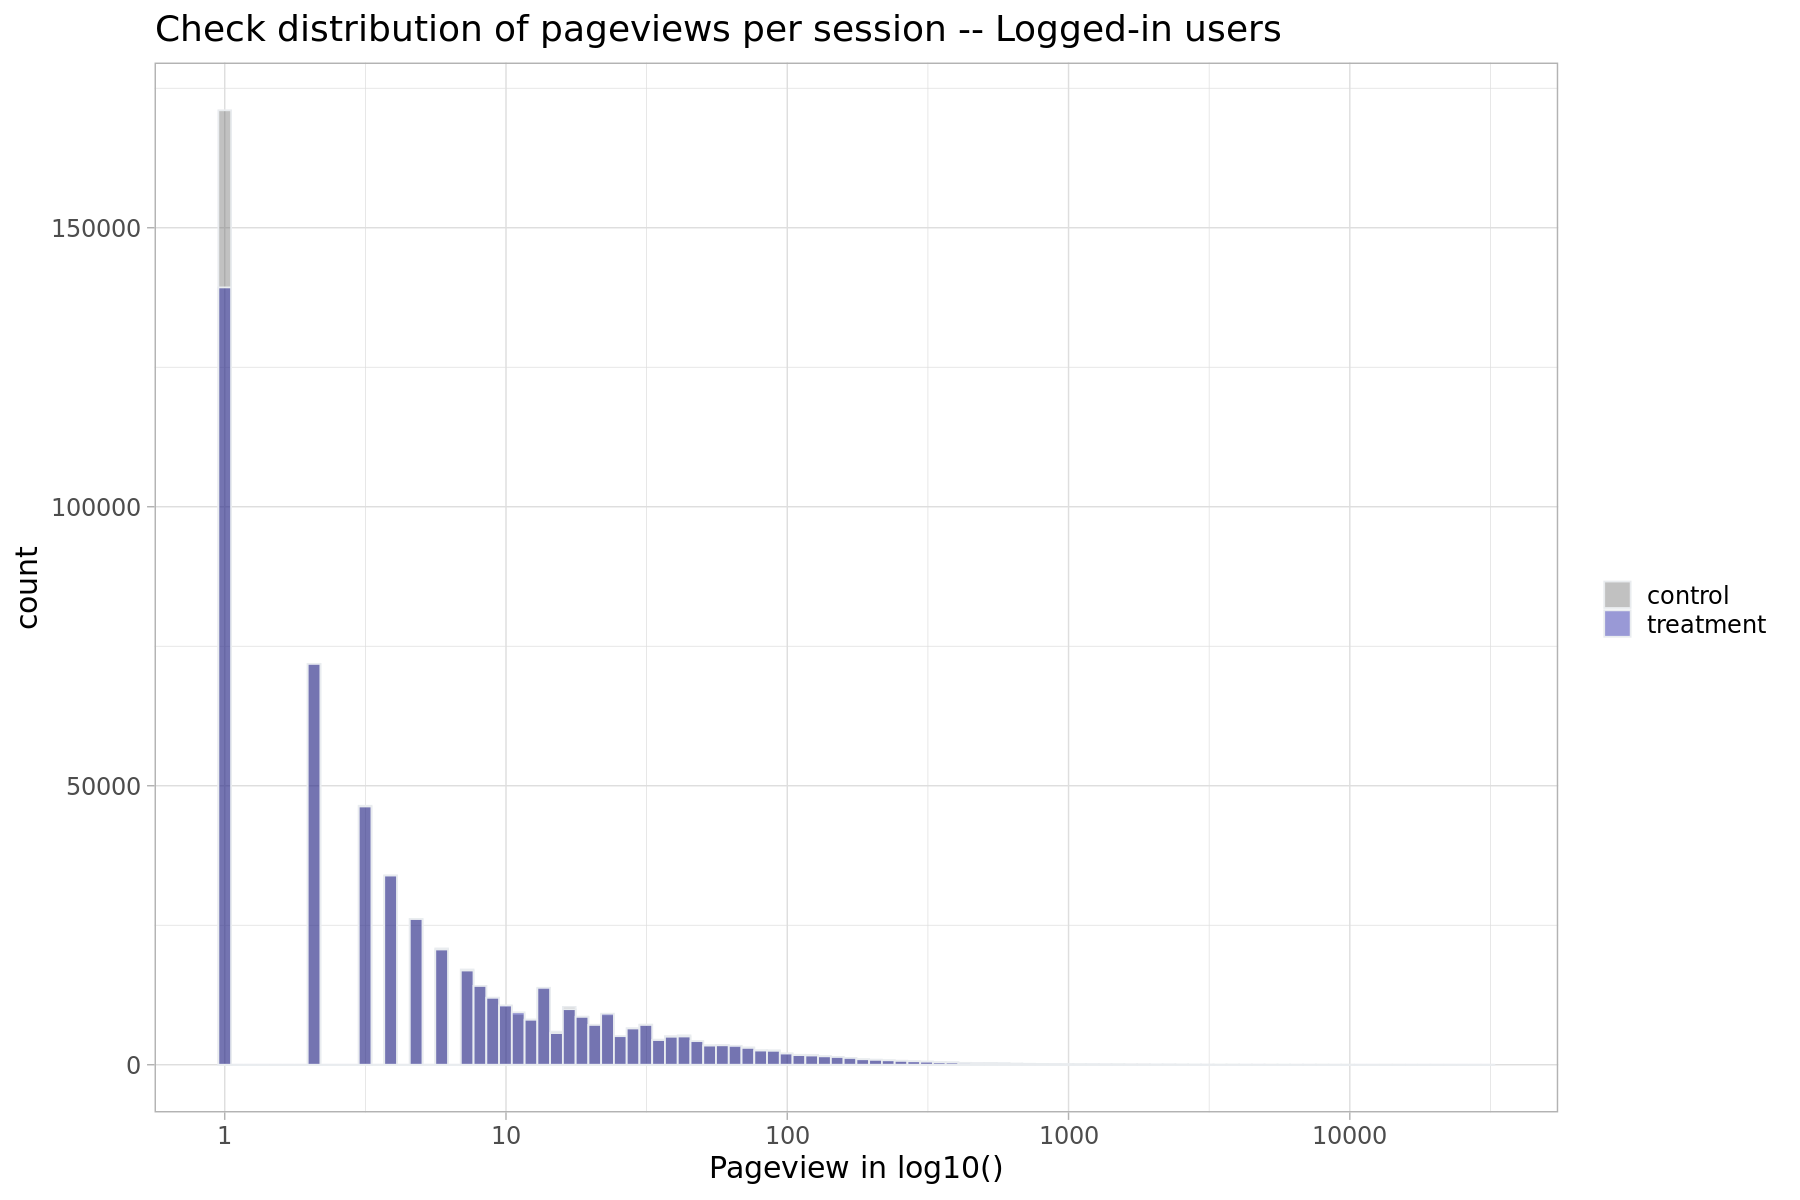

In [16]:
p1 <- df_pvs_per_session %>%
 ggplot( aes(x=sum_pvs, fill=test_group)) +
    geom_histogram( color="#e9ecef", alpha=0.4, position = 'identity', bins=100) +
    scale_x_log10() +
    scale_fill_manual(values=c("#666666", "#000099")) +
    labs ( x= "Pageview in log10()", 
          title = "Check distribution of pageviews per session -- Logged-in users",
         fill="") +
    theme_light(base_size=18)
p1

# Analysis
## By wiki

In [21]:
df_pvs_wiki <- df_pvs_per_session %>% 
  group_by( wiki ,test_group) %>%
  summarize(total_pvs=sum(sum_pvs), total_pages=sum(n_pages), n_sessions=n_distinct(session_id), ,.groups='drop') %>%
  mutate(pvs_per_sessions = round(total_pvs/n_sessions, 2) )

In [22]:
df_pvs_wiki

wiki,test_group,total_pvs,total_pages,n_sessions,pvs_per_sessions
<chr>,<chr>,<int>,<int>,<int>,<dbl>
enwiki,control,8032826,8031653,451785,17.78
enwiki,treatment,7975065,7974056,422227,18.89
fawiki,control,156055,155993,9573,16.30
fawiki,treatment,125034,125000,8954,13.96
frwiki,control,953480,953377,55295,17.24
frwiki,treatment,925160,925046,52465,17.63
hewiki,control,188825,188803,9136,20.67
hewiki,treatment,195126,195085,9777,19.96
kowiki,control,98851,98850,4728,20.91


In [84]:
df_pvs_wiki %>% 
  group_by(test_group) %>%
  summarize(all_pvs=sum(total_pvs), all_sessions=sum(n_sessions), .groups='drop' ) %>%
  mutate(pvs_per_session=round(all_pvs/all_sessions, 4))

test_group,all_pvs,all_sessions,pvs_per_session
<chr>,<int>,<int>,<dbl>
control,10056089,569972,17.6431
treatment,9868007,536839,18.3817


In [85]:
18.3817/17.6431 -1

[1] 0.04186339

### Note
We observed an 4.2% increase in the pageviews per session from the users who were shown the new page separation across all participating Wikipedias and all editor experience levels.

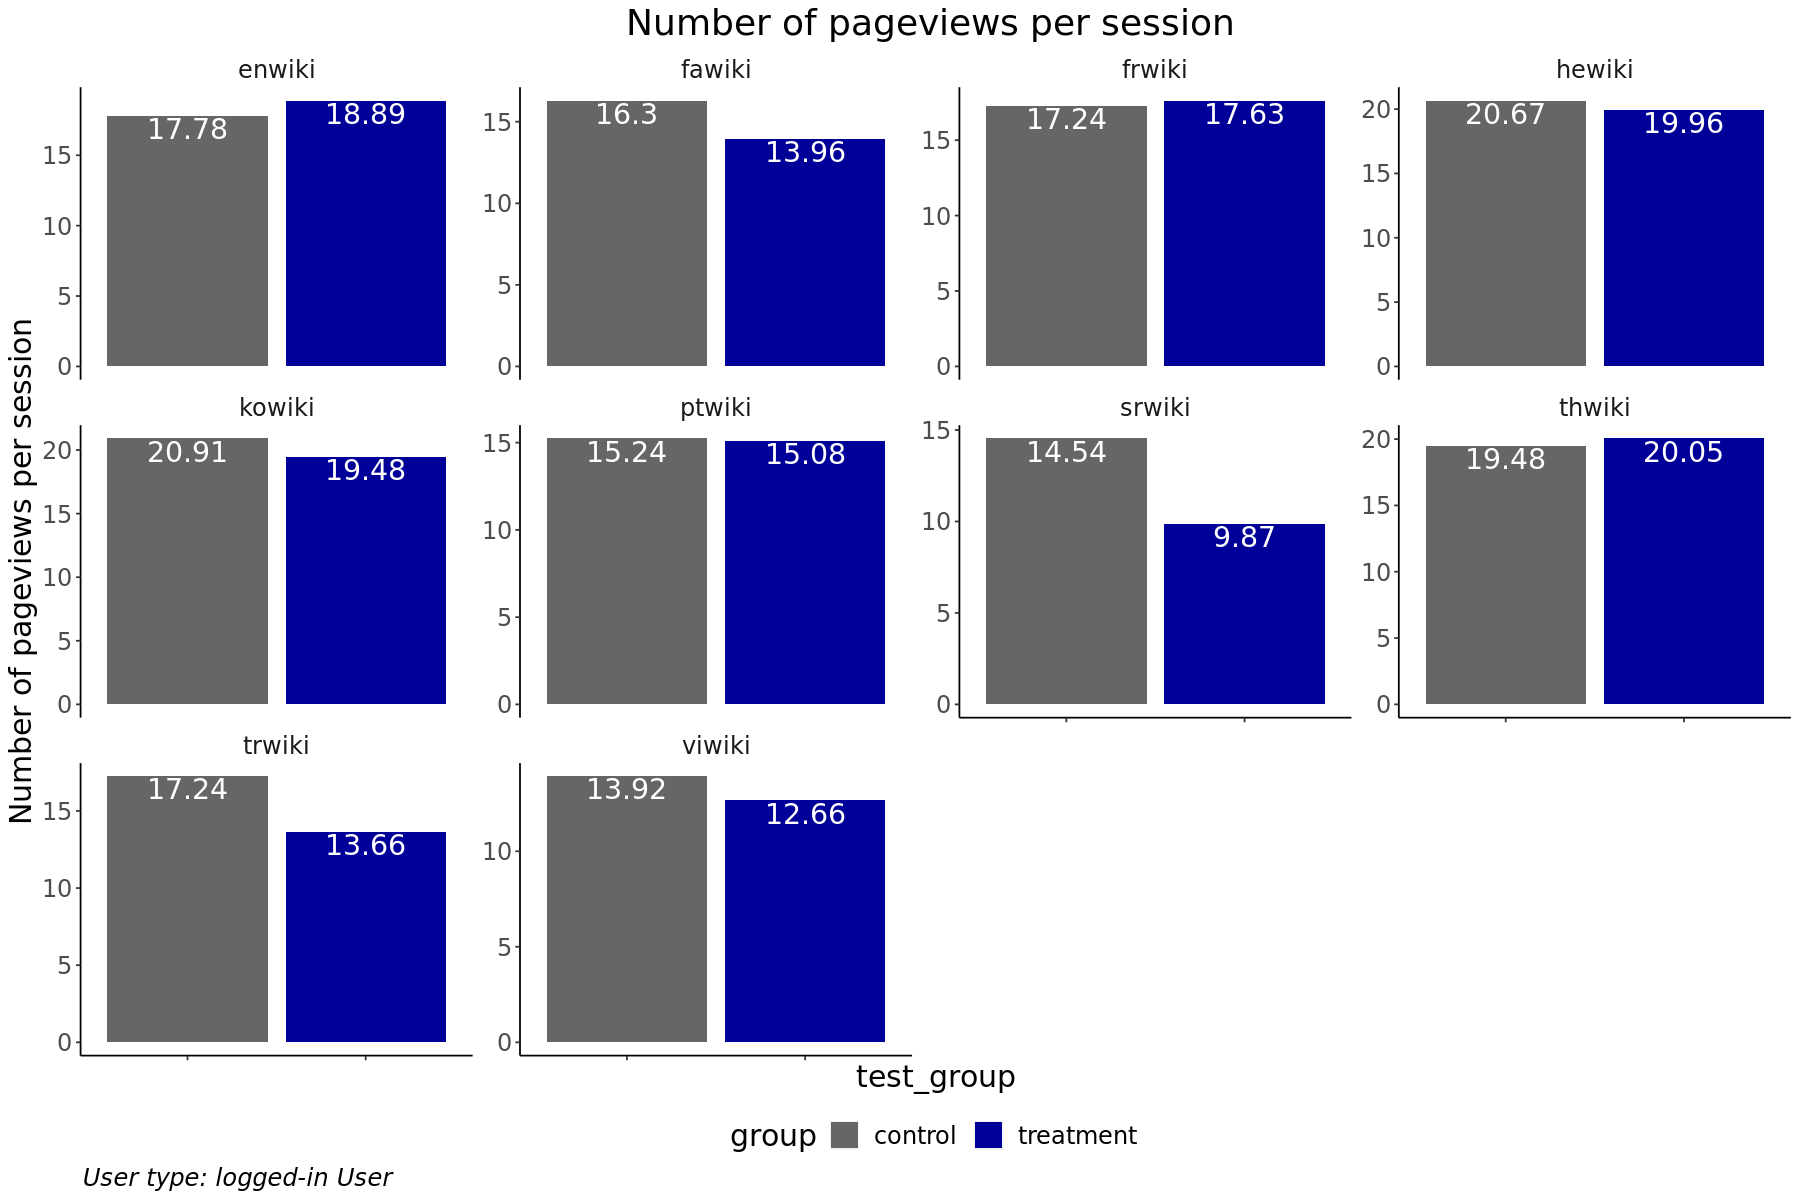

In [78]:


barchart_pvs_per_session  <- df_pvs_wiki  %>%
        select(wiki, test_group, pvs_per_sessions) %>%
        ggplot(aes(x = test_group, y= pvs_per_sessions, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(pvs_per_sessions)), color = "white", position = position_dodge(width = 1), 
                  vjust = 1.1, hjust = 0.5, size = 6) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Number of pageviews per session" ,
             title = "Number of pageviews per session " ,
             caption = "User type: logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_pvs_per_session
     


### Note

When broken down by wiki, different trends were observed.   

On 3 wikis, enwiki, frwiki and thwiki, the treatment group has more pageviews per session than the control group overall.   

On 7 other wikis, the treatment group has fewer pageviews per session than the control group overall.


## By edit bucket

In [12]:
df_pageviews %>% 
  group_by(session_id) %>%
  summarize(n_dup=n_distinct(editcountbucket), .groups='drop') %>%
  filter(n_dup>1) %>% 
  nrow()

[1] 19917

19917 sessions (1.8% of total sessions) switched edit count bucket groups during AB test. 80% of these sessions transitioned from 0 edits group to 1-4 edits group. 95.6% of these sessions transitioned in 0 edits group, 1-4 edits group and 5-99 edits group. 

We will use the initial editcount bucket that the session was in as the edit count group for the following analysis and modeling. 

In [13]:
df_pvs_bucket_per_session <-  df_pageviews %>% 
  mutate(
          editcountbucket_n = 
            case_when(
                editcountbucket == '0 edits' ~ 0 ,
                editcountbucket == '1-4 edits' ~ 4,
                editcountbucket == '5-99 edits' ~ 99,
                editcountbucket == '100-999 edits'  ~ 999,
                editcountbucket == '1000+ edits' ~ 1000,
                TRUE ~ NA
            )
        ) %>%
   group_by(session_id, wiki, test_group ) %>%
   summarize(sum_pvs=sum(pvs), sum_pv_pages=n_distinct(page_token), 
             editcountbucket_begin=min(editcountbucket_n),
             editcountbucket_end=max(editcountbucket_n),
             .groups='drop')

In [14]:
df_pvs_bucket_per_session <- df_pvs_bucket_per_session %>% 
      mutate(
          editcountbucket_lab = factor(
            case_when(
                editcountbucket_begin == 0 ~ '0_edits'  ,
                editcountbucket_begin == 4 ~ '1_4_edits' ,
                editcountbucket_begin == 99 ~ '5_99_edits' ,
                editcountbucket_begin == 999 ~ '100_999_edits'  ,
                editcountbucket_begin == 1000 ~ '1000_more_edits',
                TRUE ~ 'others'
            ), levels = c('0_edits', '1_4_edits' ,'5_99_edits', '100_999_edits', '1000_more_edits', 'other')
          ) 
         )

In [16]:
df_pvs_editbucket_overall <- df_pvs_bucket_per_session %>%
   group_by(test_group, editcountbucket_lab ) %>%
   summarize(total_pvs=sum(sum_pvs),total_pv_pages=sum(sum_pv_pages), n_sessions=n_distinct(session_id), .groups='drop') %>%
   mutate(pvs_per_sessions = round(total_pvs/n_sessions,2))

In [17]:
df_pvs_editbucket_overall

test_group,editcountbucket_lab,total_pvs,total_pv_pages,n_sessions,pvs_per_sessions
<chr>,<fct>,<int>,<int>,<int>,<dbl>
control,0_edits,1675249,1674933,186627,8.98
control,1_4_edits,828957,828788,74938,11.06
control,5_99_edits,2253880,2253578,150087,15.02
control,100_999_edits,1686450,1686178,77818,21.67
control,1000_more_edits,3611553,3611155,80502,44.86
treatment,0_edits,1551263,1550968,153733,10.09
treatment,1_4_edits,822927,822811,73213,11.24
treatment,5_99_edits,2207717,2207439,152687,14.46
treatment,100_999_edits,1750183,1749961,80104,21.85


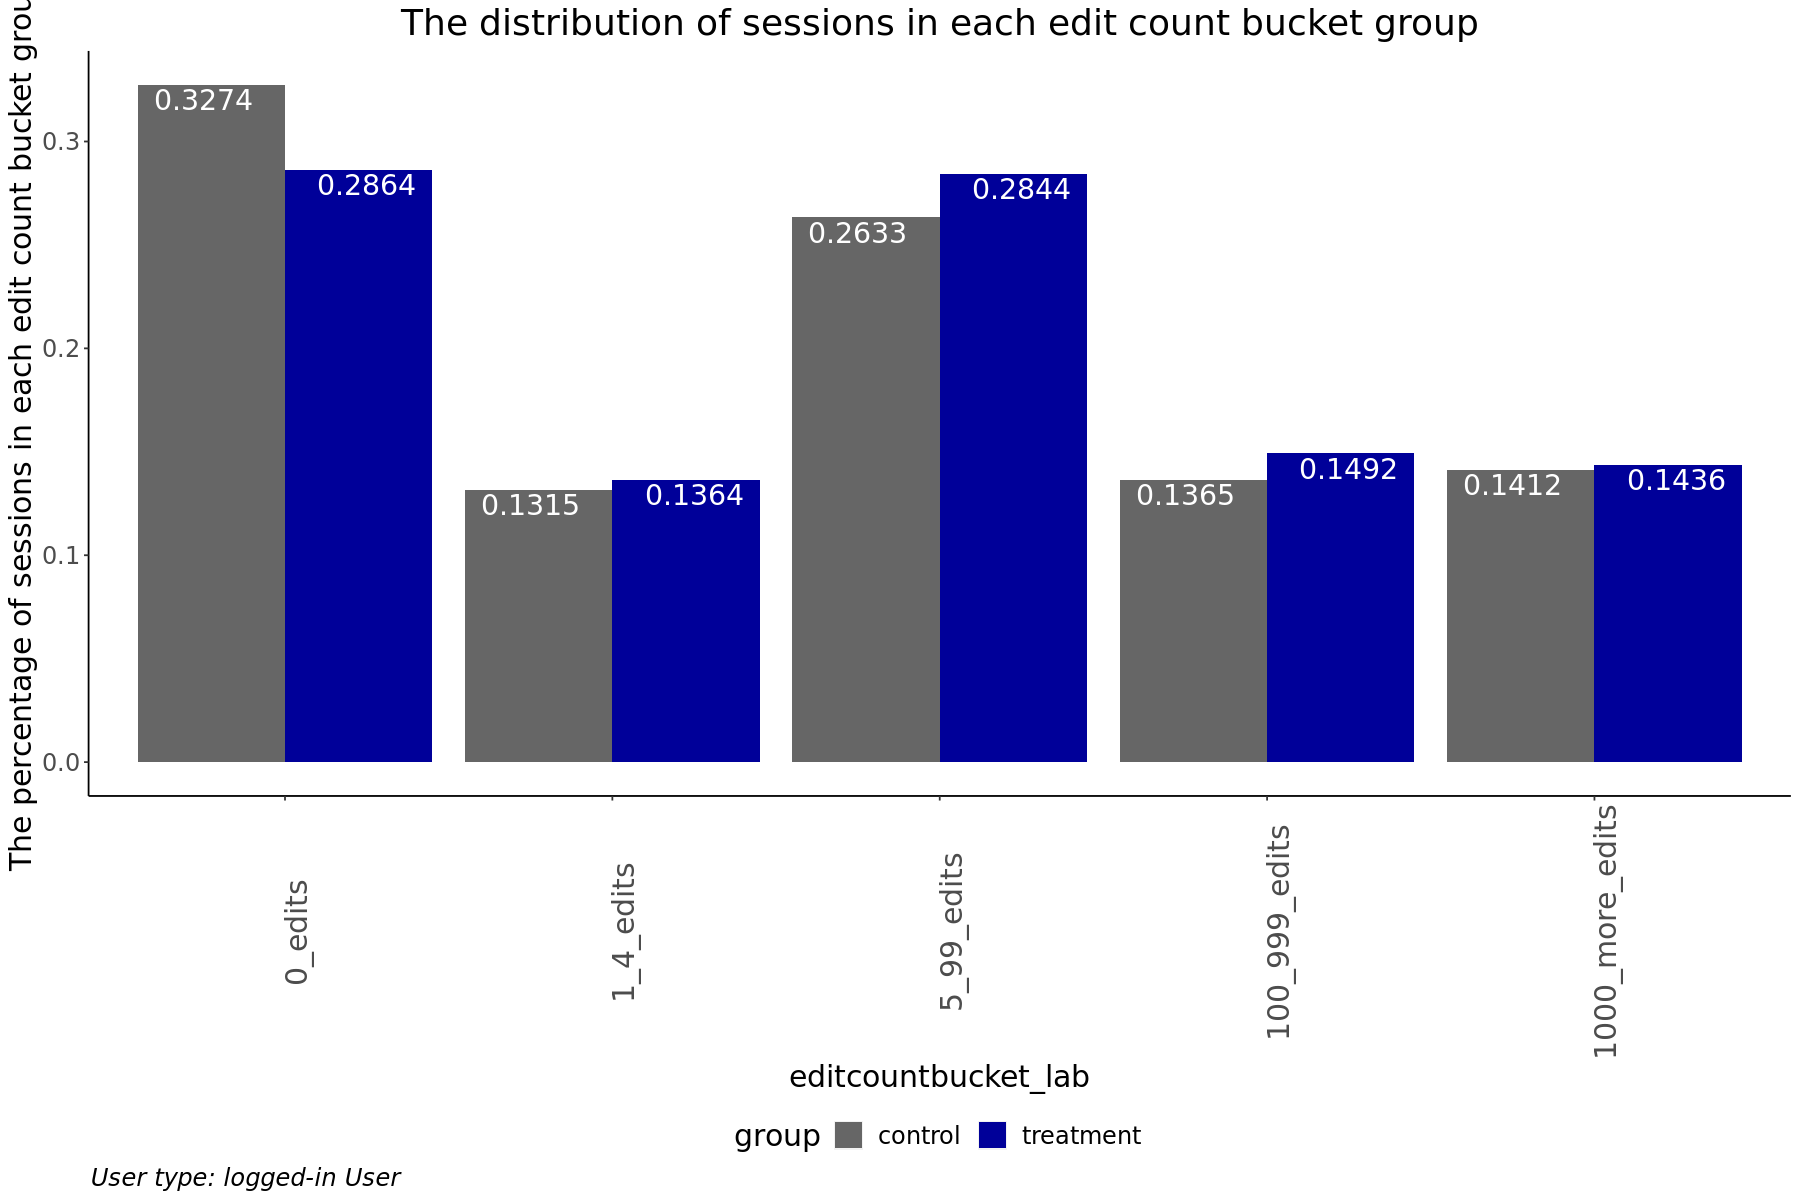

In [72]:
barchart_sessions_editcountbucket_overall <- df_pvs_editbucket_overall %>%
  group_by(test_group) %>%
  mutate(
      ptg=round(n_sessions/sum(n_sessions),4)
      ) %>% 
  ggplot(aes(x = editcountbucket_lab, y= ptg, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(ptg)), color = "white", position = position_dodge(width = 1), 
                  vjust = 1.2, hjust = 0.5, size = 6) +
        labs (
              y = "The percentage of sessions in each edit count bucket group" ,
             title = "The distribution of sessions in each edit count bucket group" ,
             caption = "User type: logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_text(angle=90, size=18),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_sessions_editcountbucket_overall

### Note 

Generally, the treatment group consists of more active editors and fewer read-only users. When conducting analysis, it is important to take into account the edit count bucket as a factor.

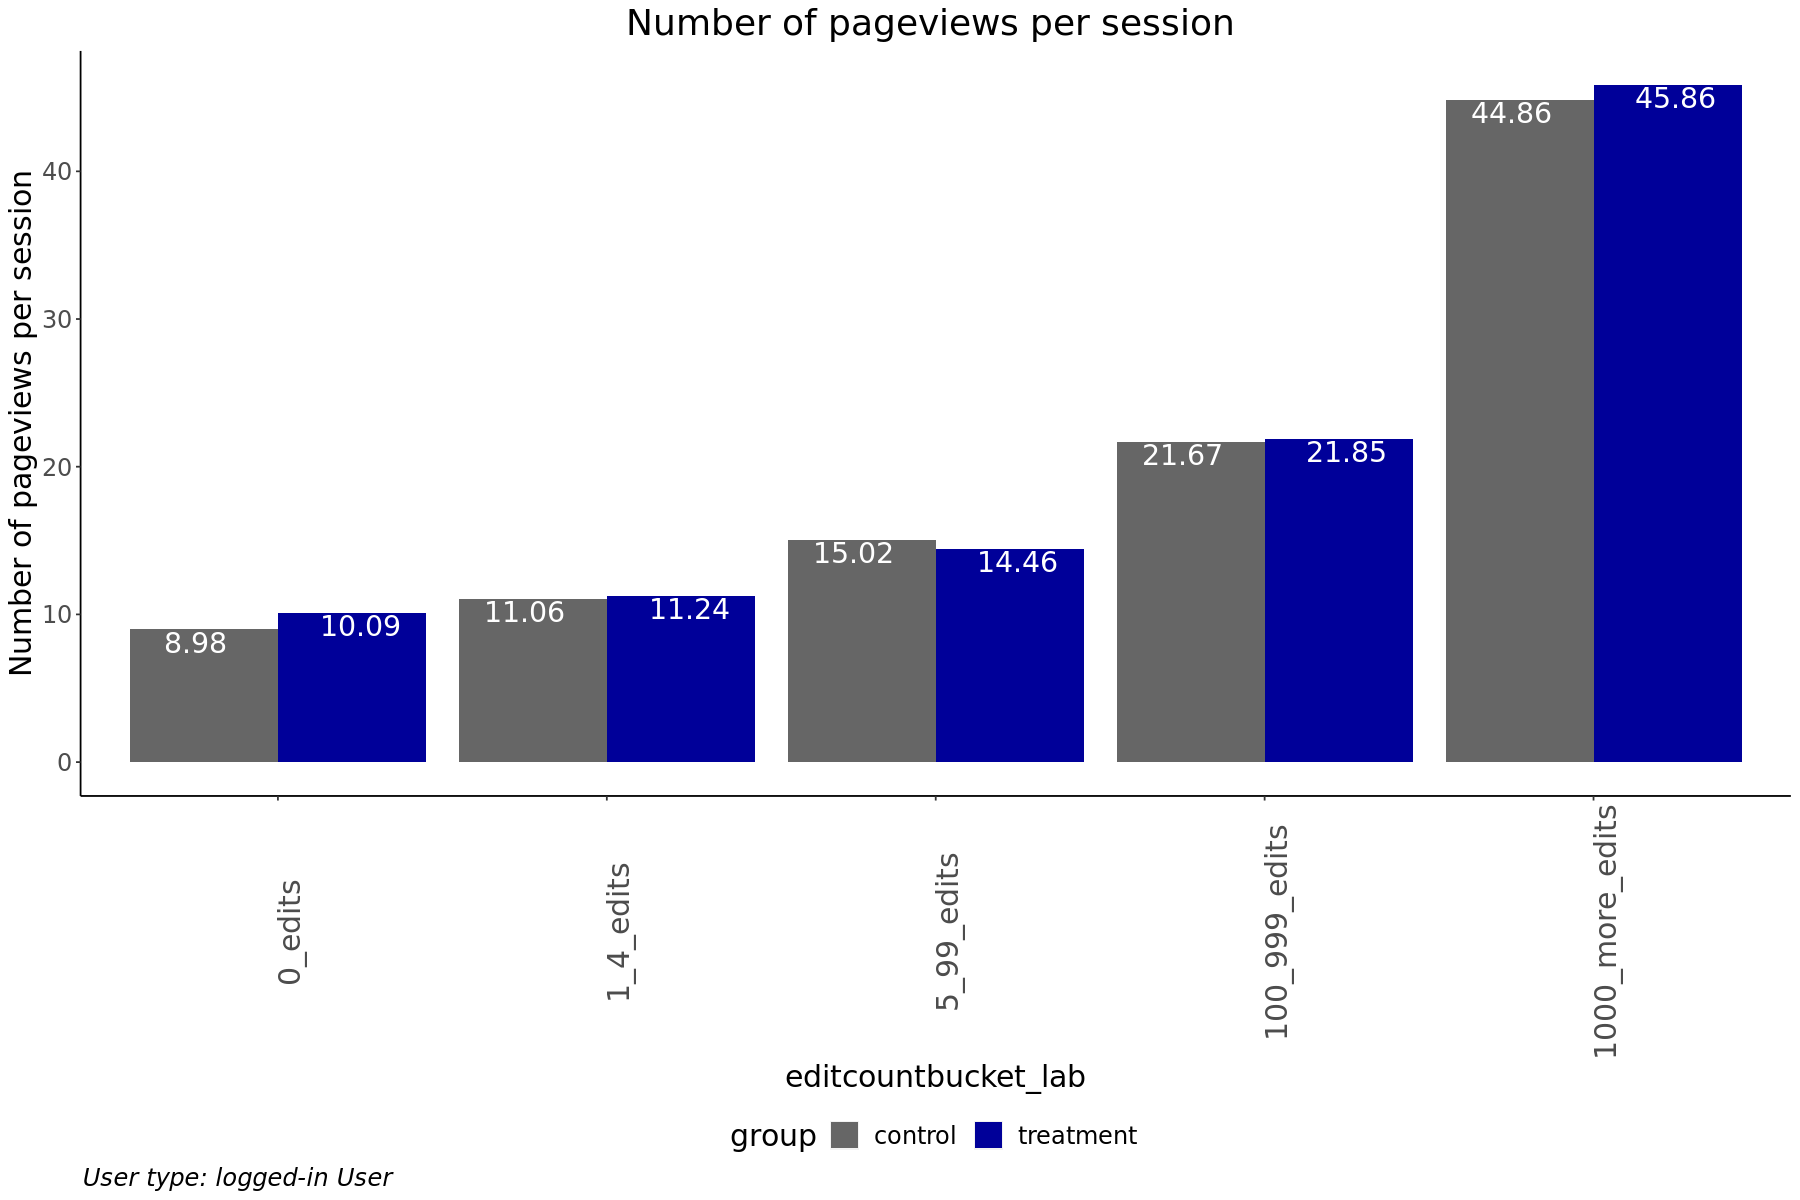

In [75]:
barchart_pvs_editcountbucket_overall  <- df_pvs_editbucket_overall  %>%
        select(editcountbucket_lab, test_group, pvs_per_sessions) %>%
        ggplot(aes(x = editcountbucket_lab, y= pvs_per_sessions, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(pvs_per_sessions)), color = "white", position = position_dodge(width = 1), 
                  vjust = 1.1, hjust = 0.5, size = 6) +
        labs (
              y = "Number of pageviews per session" ,
             title = "Number of pageviews per session " ,
             caption = "User type: logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_text(angle=90, size=18),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_pvs_editcountbucket_overall

### Note
When broken down by the edit count bucket, it was observed that the treatment group exhibited an increase in page views per session in four categories: "0 edits," "1-4 edits," "100-999 edits," and "1000+ edits." However, there was a decrease in the "5-99 edits" category. 

Additionally, it was noticed that more experienced users were more active in reading.

In [23]:
df_pvs_wiki_editbucket <- df_pvs_bucket_per_session %>%
   group_by(wiki,test_group, editcountbucket_lab ) %>%
   summarize(total_pvs=sum(sum_pvs),total_pv_pages=sum(sum_pv_pages), n_sessions=n_distinct(session_id), .groups='drop')

In [26]:
df_pvs_wiki_editbucket <- df_pvs_wiki_editbucket %>%
  mutate(pvs_per_sessions = round(total_pvs/n_sessions,2))


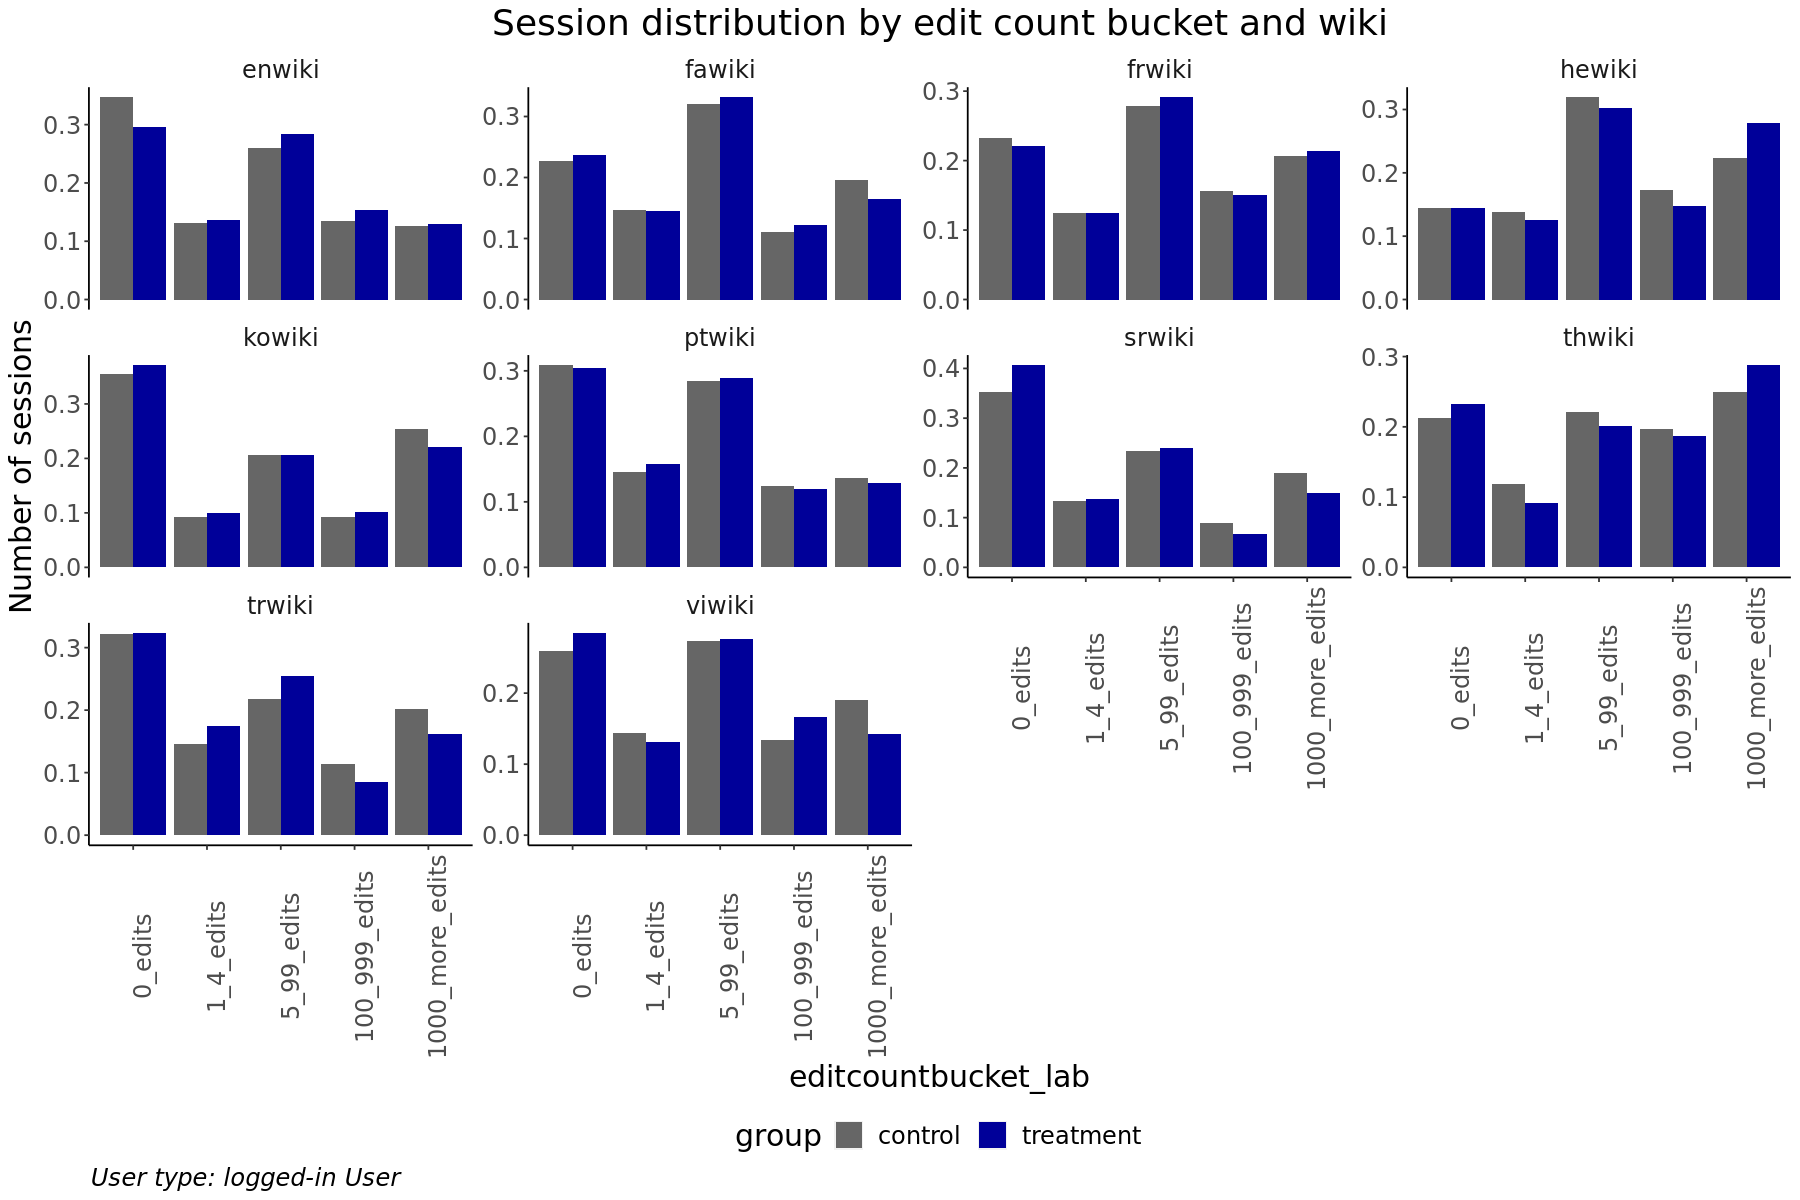

In [80]:
barchart_sessions_editcountbucket <- df_pvs_wiki_editbucket %>%
  group_by(wiki,test_group) %>%
  mutate(
      ptg=round(n_sessions/sum(n_sessions),4)
      ) %>%
 ggplot(aes(x = editcountbucket_lab, y= ptg, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Number of sessions" ,
             title = "Session distribution by edit count bucket and wiki" ,
             caption = "User type: logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_text(angle=90),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_sessions_editcountbucket
      

### Note
For each individual wiki, the distribution of sessions by edit count bucket varies slightly. 
hewiki and thwiki exhibit a higher number of active editors, while srwiki has a greater proportion of read-only users.

When conducting analysis, it is important to take into account the edit count bucket as a factor.


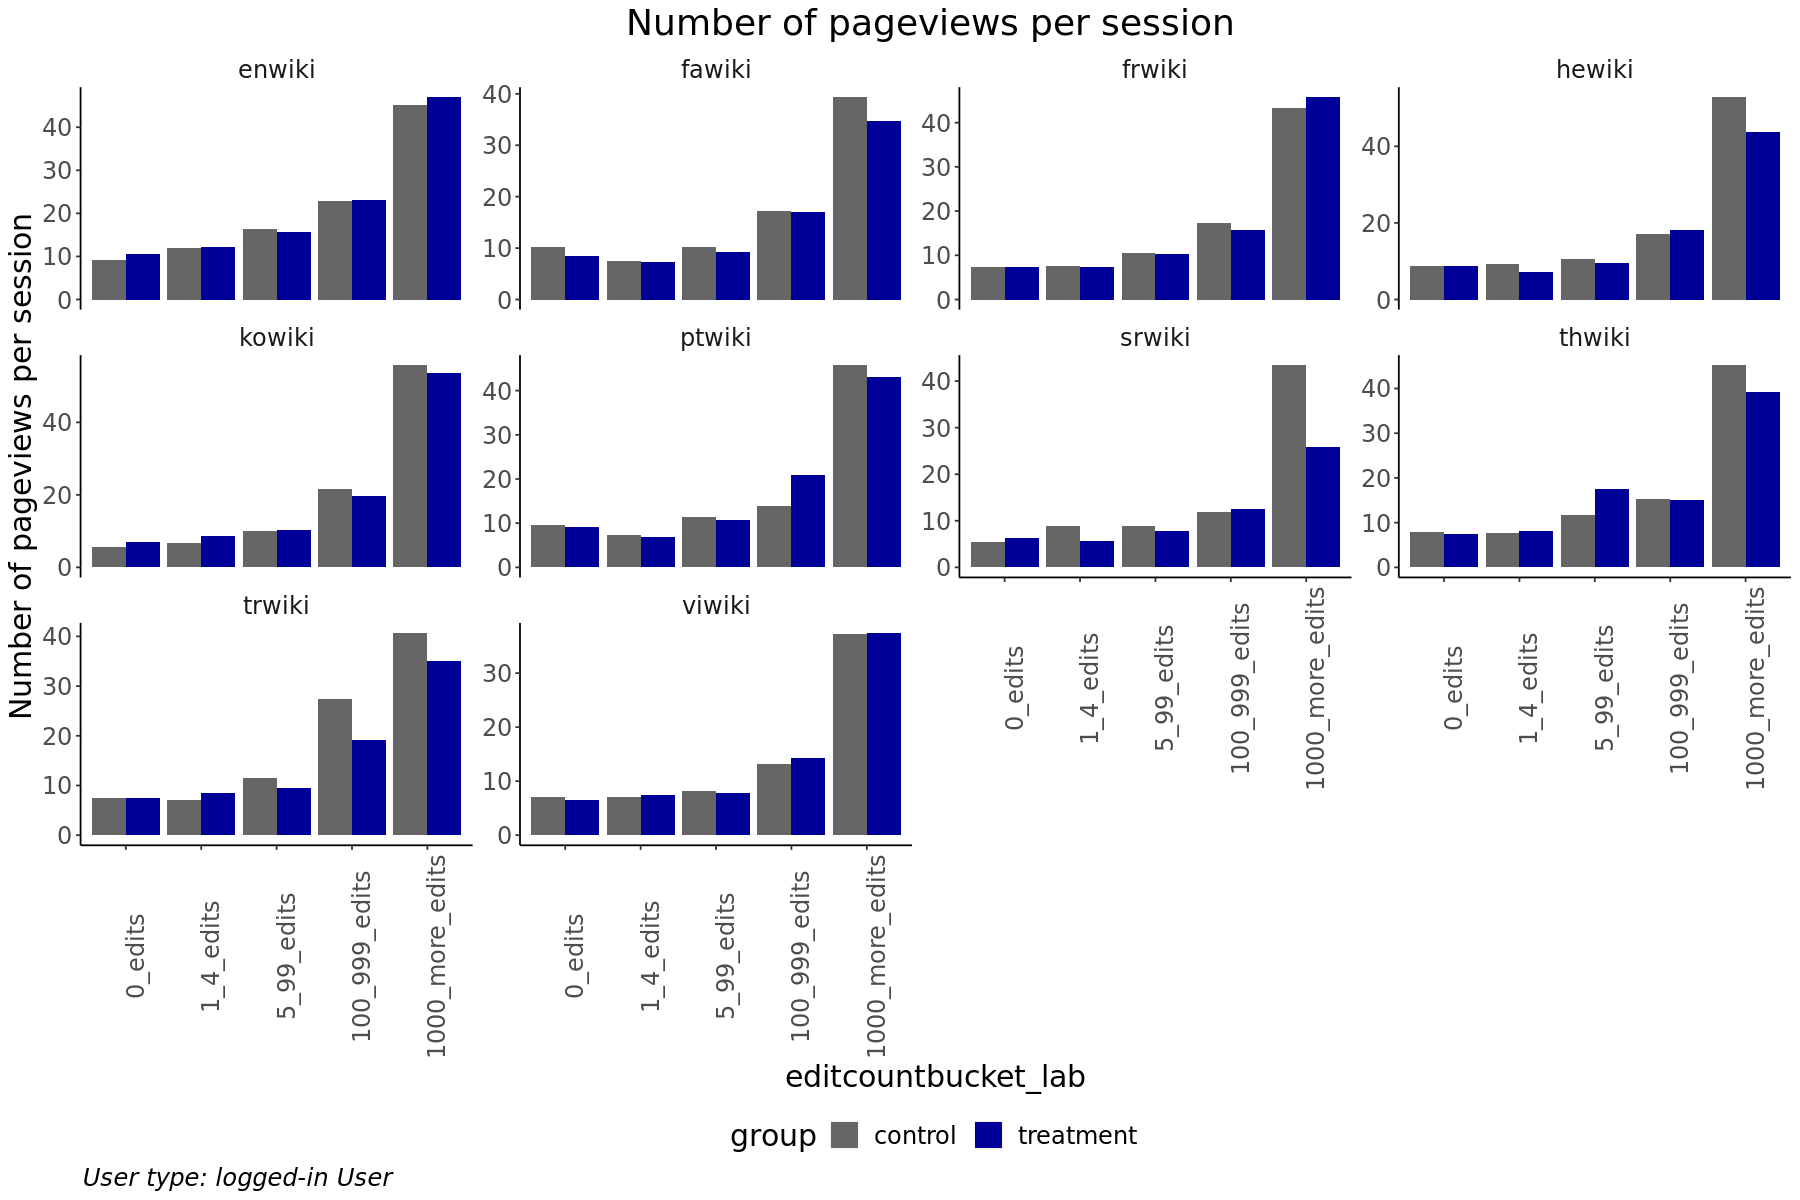

In [77]:
barchart_pvs_editcountbucket  <- df_pvs_wiki_editbucket  %>%
        select(wiki, test_group,editcountbucket_lab, pvs_per_sessions) %>%
        ggplot(aes(x = editcountbucket_lab, y= pvs_per_sessions, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Number of pageviews per session" ,
             title = "Number of pageviews per session " ,
             caption = "User type: logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_text(angle=90),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_pvs_editcountbucket

### Note
More experienced users are more active in reading.

When broken down by wiki and editor experience levels, no consistent pattern was observed across specific bucket groups. It is quite common for the treatment group to have more pageviews per session in some bucket groups while having fewer pageviews per session in other bucket groups.
Note that on srwiki, the treatment group has a significantly lower pageviews per session in 1000+ edits group than the control group.

## Modeling

In [19]:

m_1 <- glmer( formula = sum_pvs ~ test_group + (1 | wiki),
    family = poisson(link = "log"),
    data = df_pvs_per_session)


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00536028 (tol = 0.002, component 1)”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?”


In [20]:
summary(m_1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: sum_pvs ~ test_group + (1 | wiki)
   Data: df_pvs_per_session

      AIC       BIC    logLik  deviance  df.resid 
 71198706  71198742 -35599350  71198700   1106808 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
  -4.3   -3.9   -3.4   -1.6 7163.3 

Random effects:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 0.02874  0.1695  
Number of obs: 1106811, groups:  wiki, 10

Fixed effects:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)         2.7818658  0.0069705  399.09   <2e-16 ***
test_grouptreatment 0.0414258  0.0004458   92.93   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
tst_grptrtm 0.011 
optimizer (Nelder_Mead) convergence code: 0 (OK)
Model failed to converge with max|grad| = 0.00536028 (tol = 0.002, component 1)
Model is nea

In [32]:
blas_set_num_threads(8)
m_2 <- glmer( formula = sum_pvs ~ test_group + (1 | wiki),
    family = poisson(link = "identity"),
    data = df_pvs_per_session )
blas_set_num_threads(1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00602657 (tol = 0.002, component 1)”


In [33]:
summary(m_2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( identity )
Formula: sum_pvs ~ test_group + (1 | wiki)
   Data: df_pvs_per_session

      AIC       BIC    logLik  deviance  df.resid 
 71199732  71199768 -35599863  71199726   1106808 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
  -4.3   -3.9   -3.4   -1.5 7170.1 

Random effects:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 7.495    2.738   
Number of obs: 1106811, groups:  wiki, 10

Fixed effects:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)         16.412826   0.022978   714.3   <2e-16 ***
test_grouptreatment  0.698699   0.004746   147.2   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
tst_grptrtm 0.444 
optimizer (Nelder_Mead) convergence code: 0 (OK)
Model failed to converge with max|grad| = 0.00602657 (tol = 0.002, component 1)


### Note
Discard m_1 and m_2 as they failed to converge. Switch to glmmTMB(), which provides dispformula. 
It is a one-sided formula for dispersion containing only fixed effects: the default ~1 specifies the standard dispersion given any family. 

In [35]:
blas_set_num_threads(8)
m_3 <- glmmTMB( formula =  sum_pvs ~ test_group + (1 | wiki),     
    family = nbinom2,
    data = df_pvs_per_session)
blas_set_num_threads(1)

In [36]:
summary(m_3)

 Family: nbinom2  ( log )
Formula:          sum_pvs ~ test_group + (1 | wiki)
Data: df_pvs_per_session

     AIC      BIC   logLik deviance df.resid 
 8144979  8145027 -4072486  8144971  1106807 

Random effects:

Conditional model:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 0.02798  0.1673  
Number of obs: 1106811, groups:  wiki, 10

Dispersion parameter for nbinom2 family (): 0.46 

Conditional model:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)          2.78515    0.05307   52.48   <2e-16 ***
test_grouptreatment  0.03904    0.00284   13.74   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [37]:
blas_set_num_threads(8)
m_4 <- glmmTMB( formula =  sum_pvs ~ test_group + (1 | wiki),     
    family = poisson(link = "log"),
    data = df_pvs_per_session)
blas_set_num_threads(1)

In [38]:
summary(m_4)

 Family: poisson  ( log )
Formula:          sum_pvs ~ test_group + (1 | wiki)
Data: df_pvs_per_session

      AIC       BIC    logLik  deviance  df.resid 
 71198706  71198742 -35599350  71198700   1106808 

Random effects:

Conditional model:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 0.02866  0.1693  
Number of obs: 1106811, groups:  wiki, 10

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)         2.7825454  0.0535428   51.97   <2e-16 ***
test_grouptreatment 0.0414270  0.0004481   92.45   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [33]:
blas_set_num_threads(8)
m_5 <- glmmTMB( formula =  sum_pvs ~ test_group + editcountbucket_lab + (1 | wiki),     
    family = nbinom2,
    data = df_pvs_bucket_per_session)
blas_set_num_threads(1)

In [34]:
summary(m_5)

 Family: nbinom2  ( log )
Formula:          sum_pvs ~ test_group + editcountbucket_lab + (1 | wiki)
Data: df_pvs_bucket_per_session

     AIC      BIC   logLik deviance df.resid 
 7974689  7974785 -3987337  7974673  1106803 

Random effects:

Conditional model:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 0.01739  0.1319  
Number of obs: 1106811, groups:  wiki, 10

Dispersion parameter for nbinom2 family (): 0.516 

Conditional model:
                                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)                        2.003095   0.041955    47.7   <2e-16 ***
test_grouptreatment                0.029554   0.002698    11.0   <2e-16 ***
editcountbucket_lab1_4_edits       0.162346   0.004441    36.6   <2e-16 ***
editcountbucket_lab5_99_edits      0.443570   0.003558   124.7   <2e-16 ***
editcountbucket_lab100_999_edits   0.836281   0.004316   193.8   <2e-16 ***
editcountbucket_lab1000_more_edits 1.607976   0.004342   370.3   <2e-16 ***
---
Signif. code

In [44]:
r.squaredGLMM(m_3) 

Warning message:
“'r.squaredGLMM' now calculates a revised statistic. See the help page.”
Warning message in r.squaredGLMM.glmmTMB(m_3):
“the effects of zero-inflation and dispersion model are ignored”
Warning message:
“the null model is correct only if all variables used by the original model remain unchanged.”


,R2m,R2c
delta,1.683122e-04,0.012543015
lognormal,3.167111e-04,0.023602040
trigamma,6.349193e-05,0.004731565


In [37]:
r.squaredGLMM(m_5) 

Warning message in r.squaredGLMM.glmmTMB(m_5):
“the effects of zero-inflation and dispersion model are ignored”
Warning message:
“the null model is correct only if all variables used by the original model remain unchanged.”


,R2m,R2c
delta,0.12368459,0.13124465
lognormal,0.20321358,0.21563475
trigamma,0.05440715,0.05773271


### Note

Adding  editcountbucket_lab as control varibale improved R-squared from 3.167111e-04 to 0.20321358.   
Choose m_5 model based on the low AIC and improved R-squared.



### Estimate the impact

In [38]:
fixef(m_5)


Conditional model:
                       (Intercept)                 test_grouptreatment  
                           2.00309                             0.02955  
      editcountbucket_lab1_4_edits       editcountbucket_lab5_99_edits  
                           0.16235                             0.44357  
  editcountbucket_lab100_999_edits  editcountbucket_lab1000_more_edits  
                           0.83628                             1.60798  

In [35]:
exp(0.029554)

[1] 1.029995

### Conclusion
p-value < 2e-16. coefficient of test_grouptreatment is 0.029554 > 0. It means that the treatment group exhibits a __3.00% increase__ in pageviews compared to the control group.

But only 20%(R2m) of variance is explained by the model with fix variable test_group, edit count bucket and random variable wiki. It means some other factors played role in influnce the number of pageviews. 